# BigMart Sales Prediction: Detailed & Thoughtful Approach

This notebook presents a comprehensive, step-by-step solution for the BigMart sales prediction challenge. The focus is on deep feature engineering, robust preprocessing, and advanced model selection/tuning to maximize predictive performance.

---

## Outline
1. Introduction & Problem Statement
2. Import Required Libraries
3. Data Loading & Initial Exploration
4. Data Cleaning & Imputation
5. Exploratory Data Analysis (EDA)
6. Advanced Feature Engineering
7. Data Preprocessing & Encoding
8. Model Selection & Hyperparameter Tuning
9. Model Evaluation
10. Final Prediction & Submission
11. Conclusion & Next Steps


## 1. Introduction & Problem Statement

The goal is to predict the sales of each product at various BigMart outlets using historical sales data. This notebook will focus on:
- Deep data exploration and visualization
- Advanced feature engineering (domain-driven and statistical)
- Robust handling of missing values and outliers
- Model selection with extensive hyperparameter tuning
- Stacking/blending of top models for best results


In [1]:
# 2. Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

# For feature selection and interpretation
import shap


In [12]:
# 3. Data Loading & Initial Exploration
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head())
display(test.head())

# Check for missing values and data types
print('\nMissing values in train:')
display(train.isnull().sum())
print('\nMissing values in test:')
display(test.isnull().sum())
print('\nTrain info:')
train.info()


Train shape: (8523, 12)
Test shape: (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3



Missing values in train:


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


Missing values in test:


Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
# 4. Data Cleaning & Imputation
# Fix inconsistent Item_Fat_Content
fat_map = {'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular', 'Low Fat': 'Low Fat', 'Regular': 'Regular'}
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.lower().map(fat_map)
test['Item_Fat_Content'] = test['Item_Fat_Content'].str.lower().map(fat_map)

# Impute missing Item_Weight with median by Item_Identifier
item_weight_map = train.groupby('Item_Identifier')['Item_Weight'].transform('median')
train['Item_Weight'] = train['Item_Weight'].fillna(item_weight_map)
test['Item_Weight'] = test['Item_Weight'].fillna(item_weight_map)
train['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].median())
test['Item_Weight'] = test['Item_Weight'].fillna(train['Item_Weight'].median())

# Impute missing Outlet_Size with mode by Outlet_Type
outlet_size_map = train.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
train['Outlet_Size'] = train.apply(lambda x: outlet_size_map[x['Outlet_Type']] if pd.isnull(x['Outlet_Size']) else x['Outlet_Size'], axis=1)
test['Outlet_Size'] = test.apply(lambda x: outlet_size_map[x['Outlet_Type']] if pd.isnull(x['Outlet_Size']) else x['Outlet_Size'], axis=1)

# Fix Item_Visibility: replace zeros with median by Item_Type
for df in [train, test]:
    zero_vis = df['Item_Visibility'] == 0
    df.loc[zero_vis, 'Item_Visibility'] = df.groupby('Item_Type')['Item_Visibility'].transform('median')[zero_vis]

# Outlier handling: cap Item_Visibility at 99th percentile
for df in [train, test]:
    cap = df['Item_Visibility'].quantile(0.99)
    df['Item_Visibility'] = np.where(df['Item_Visibility'] > cap, cap, df['Item_Visibility'])

print('Data cleaning and imputation complete.')

Data cleaning and imputation complete.


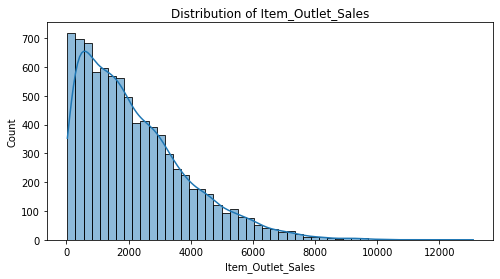

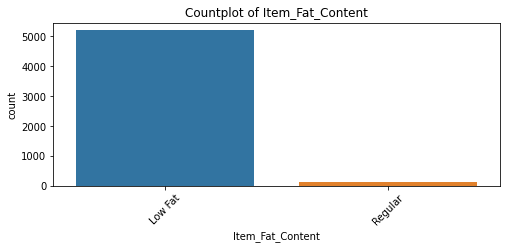

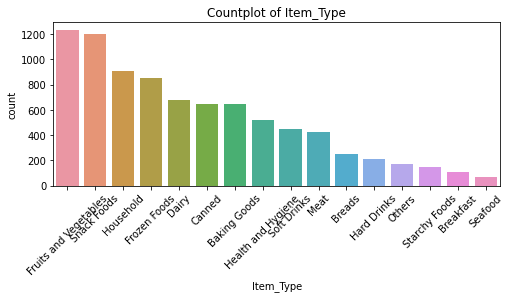

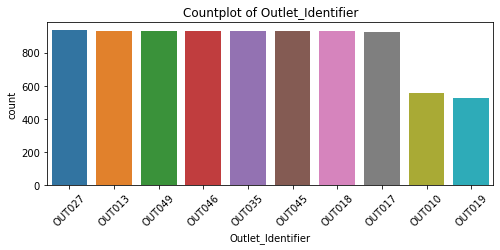

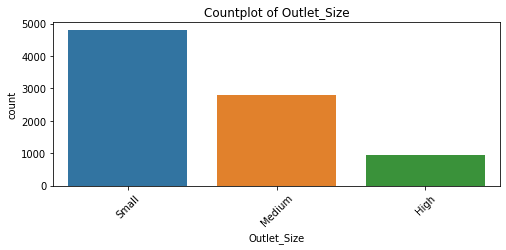

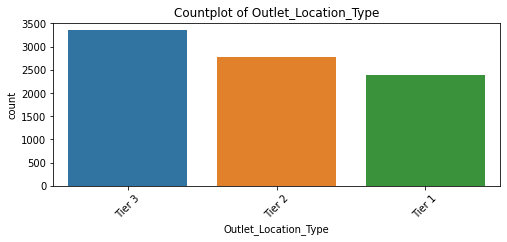

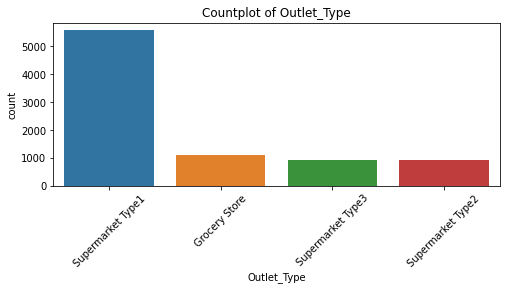

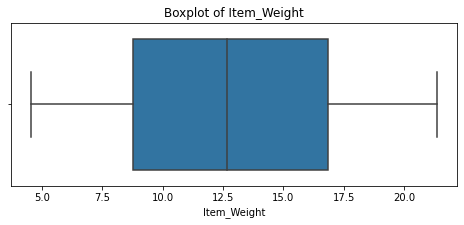

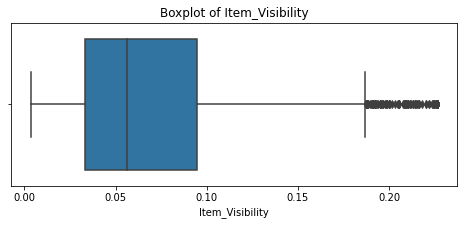

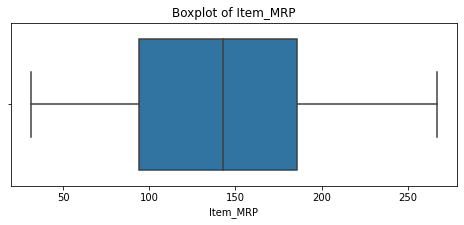

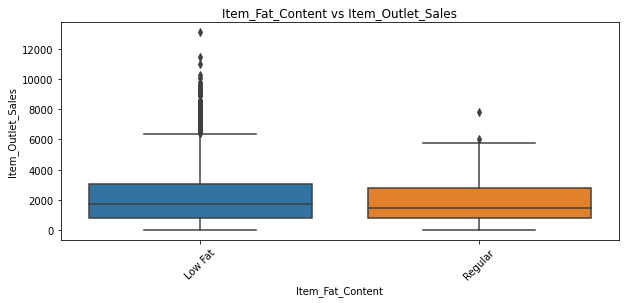

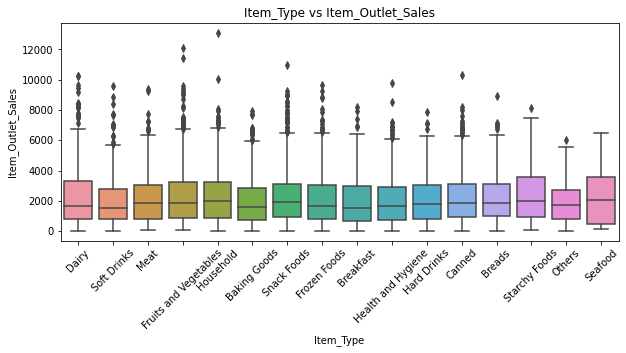

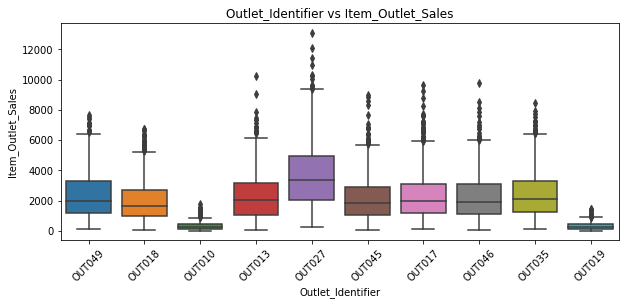

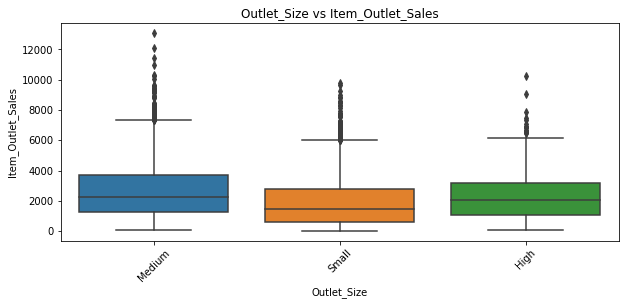

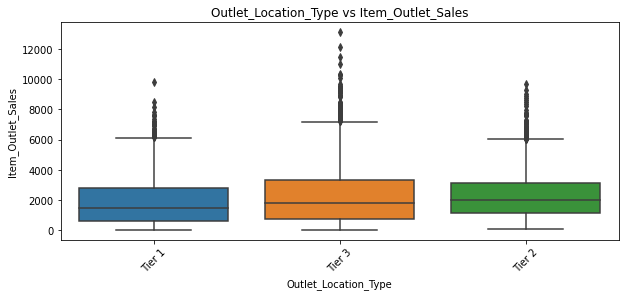

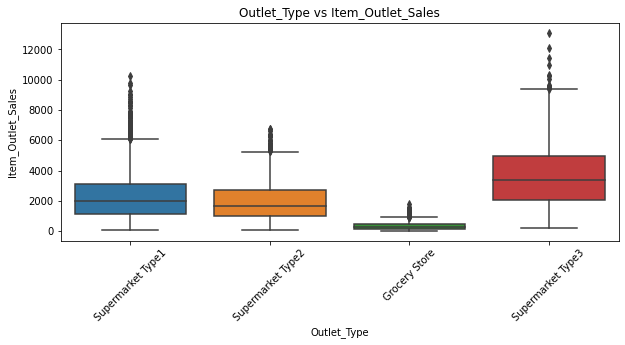

In [14]:
# 5. Exploratory Data Analysis (EDA)
# Target variable distribution
plt.figure(figsize=(8,4))
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.show()

# Categorical features: countplots
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
for col in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Numerical features: boxplots vs target
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Relationship with target
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=train, x=col, y='Item_Outlet_Sales')
    plt.title(f'{col} vs Item_Outlet_Sales')
    plt.xticks(rotation=45)
    plt.show()


In [15]:
# 6. Advanced Feature Engineering
# Item category from Item_Identifier
for df in [train, test]:
    df['Item_Category'] = df['Item_Identifier'].str[:2]
    df['Is_Food'] = df['Item_Category'].isin(['FD']).astype(int)
    df['Is_Drink'] = df['Item_Category'].isin(['DR']).astype(int)
    df['Is_NonConsumable'] = df['Item_Category'].isin(['NC']).astype(int)

# Years since establishment
for df in [train, test]:
    df['Outlet_Years'] = 2025 - df['Outlet_Establishment_Year']

# Item visibility mean ratio (relative to mean for that item)
item_vis_mean = train.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
train['Item_Visibility_MeanRatio'] = train['Item_Visibility'] / item_vis_mean
item_vis_mean_test = test.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
test['Item_Visibility_MeanRatio'] = test['Item_Visibility'] / item_vis_mean_test

# Price per weight
for df in [train, test]:
    df['Price_per_Weight'] = df['Item_MRP'] / (df['Item_Weight'] + 1e-3)

# Outlet sales type: Supermarket vs Grocery
for df in [train, test]:
    df['Is_Supermarket'] = df['Outlet_Type'].apply(lambda x: 1 if 'Supermarket' in str(x) else 0)

# Item MRP bins
for df in [train, test]:
    df['MRP_bin'] = pd.cut(df['Item_MRP'], bins=[0,70,140,200,400], labels=[0,1,2,3])

# Frequency encoding for Item_Type
item_type_freq = train['Item_Type'].value_counts().to_dict()
train['Item_Type_Freq'] = train['Item_Type'].map(item_type_freq)
test['Item_Type_Freq'] = test['Item_Type'].map(item_type_freq)

print('feature engineering complete.')

feature engineering complete.


In [16]:
# 7. Data Preprocessing & Encoding
# Label encode ordinal/categorical columns
label_cols = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Category', 'MRP_bin']
le = LabelEncoder()
for col in label_cols:
    for df in [train, test]:
        df[col] = le.fit_transform(df[col].astype(str))

# One-hot encode Item_Type (high cardinality, so use top 10 only)
top_types = train['Item_Type'].value_counts().nlargest(10).index
for df in [train, test]:
    for t in top_types:
        df[f'Item_Type_{t}'] = (df['Item_Type'] == t).astype(int)

# Scale numerical features
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Visibility_MeanRatio', 'Price_per_Weight', 'Outlet_Years', 'Item_Type_Freq']
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Prepare final train/test sets
X = train.drop(['Item_Identifier', 'Item_Outlet_Sales', 'Item_Type'], axis=1)
y = train['Item_Outlet_Sales']
X_test = test.drop(['Item_Identifier', 'Item_Type'], axis=1)

In [ ]:
# Feature selection using RFECV

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Use a simple model for feature ranking (RandomForest)
estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator, step=1, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_].tolist()
print("Selected features:", selected_features)

# Reduce X and X_test to selected features
X = X[selected_features]
X_test = X_test[selected_features]

Optimal number of features: 7
Selected features: ['Item_Visibility_MeanRatio', 'Outlet_TargetEnc', 'Item_Sales_Volatility', 'MRP_Outlet_Years', 'Outlet_Avg_Sales', 'Item_Avg_Sales', 'Outlet_ItemType_MeanSales']


In [19]:
# Feature selection using Boruta
# Boruta is a wrapper method that uses a Random Forest classifier to find important features
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=7)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, perc=85, max_iter=100)
boruta_selector.fit(X.values, y.values)

selected_features = X.columns[boruta_selector.support_].tolist()
print(f"Selected {len(selected_features)} features by Boruta:", selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	19
I

In [21]:
print(f"list of selected features we will use: {selected_features}")

list of selected features we will use: ['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Type', 'Outlet_Years', 'Item_Visibility_MeanRatio', 'Is_Supermarket']


In [22]:
X = X[selected_features]
X_test = X_test[selected_features]
# Train/validation split for local validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Hyperparameter Tuning with Optuna
import optuna
from sklearn.model_selection import cross_val_score

# Random Forest Optuna tuning
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }
    model = RandomForestRegressor(random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return -score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=30)
print('Best RF params:', study_rf.best_params)

# XGBoost Optuna tuning
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    }
    model = xgb.XGBRegressor(random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return -score

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)
print('Best XGB params:', study_xgb.best_params)

# LightGBM Optuna tuning
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    }
    model = lgb.LGBMRegressor(random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return -score

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=10)
print('Best LGBM params:', study_lgb.best_params)

# CatBoost Optuna tuning
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.05),
    }

    model = cb.CatBoostRegressor(verbose=0, random_state=42, **params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return -score

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=60)
print('Best CatBoost params:', study_cat.best_params)

[I 2025-07-27 23:09:22,752] A new study created in memory with name: no-name-61d0f516-d99b-49e6-aebe-24e353e1d397
[I 2025-07-27 23:10:20,538] Trial 0 finished with value: 1146.667253816911 and parameters: {'n_estimators': 830, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 0 with value: 1146.667253816911.
[I 2025-07-27 23:11:14,272] Trial 1 finished with value: 1123.8449107059619 and parameters: {'n_estimators': 953, 'max_depth': 12, 'min_samples_split': 9}. Best is trial 1 with value: 1123.8449107059619.
[I 2025-07-27 23:11:30,281] Trial 2 finished with value: 1101.6293111922469 and parameters: {'n_estimators': 475, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 2 with value: 1101.6293111922469.
[I 2025-07-27 23:12:28,704] Trial 3 finished with value: 1139.3332109897997 and parameters: {'n_estimators': 855, 'max_depth': 20, 'min_samples_split': 9}. Best is trial 2 with value: 1101.6293111922469.
[I 2025-07-27 23:12:39,126] Trial 4 finished with value: 1098.08058179400

Best RF params: {'n_estimators': 310, 'max_depth': 5, 'min_samples_split': 3}


[I 2025-07-27 23:20:13,952] Trial 0 finished with value: 1266.844628869657 and parameters: {'n_estimators': 456, 'max_depth': 11, 'learning_rate': 0.11003642019753919}. Best is trial 0 with value: 1266.844628869657.
[I 2025-07-27 23:20:19,928] Trial 1 finished with value: 1273.2801555129051 and parameters: {'n_estimators': 419, 'max_depth': 11, 'learning_rate': 0.2272231918035677}. Best is trial 0 with value: 1266.844628869657.
[I 2025-07-27 23:20:20,296] Trial 2 finished with value: 1099.5284761208018 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.05608529990757859}. Best is trial 2 with value: 1099.5284761208018.
[I 2025-07-27 23:20:33,429] Trial 3 finished with value: 1268.2670155542412 and parameters: {'n_estimators': 883, 'max_depth': 11, 'learning_rate': 0.1775710896888486}. Best is trial 2 with value: 1099.5284761208018.
[I 2025-07-27 23:20:35,426] Trial 4 finished with value: 1274.8982825258972 and parameters: {'n_estimators': 247, 'max_depth': 8, 'lea

Best XGB params: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.03697798438810827}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set

[I 2025-07-27 23:21:23,875] Trial 0 finished with value: 1321.4392316904507 and parameters: {'n_estimators': 652, 'max_depth': 12, 'learning_rate': 0.23704746720348566}. Best is trial 0 with value: 1321.4392316904507.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

[I 2025-07-27 23:21:24,390] Trial 1 finished with value: 1251.9517947199095 and parameters: {'n_estimators': 214, 'max_depth': 11, 'learning_rate': 0.26842591912613434}. Best is trial 1 with value: 1251.9517947199095.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-07-27 23:21:25,679] Trial 2 finished with value: 1161.658735988025 and parameters: {'n_estimators': 635, 'max_depth': 5, 'learning_rate': 0.0634533906786071}. Best is trial 2 with value: 1161.658735988025.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-27 23:21:27,772] Trial 3 finished with value: 1309.2548496329234 and parameters: {'n_estimators': 685, 'max_depth': 7, 'learning_rate': 0.24753549720883758}. Best is trial 2 with value: 1161.658735988025.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-07-27 23:21:30,125] Trial 4 finished with value: 1305.050726972432 and parameters: {'n_estimators': 886, 'max_depth': 8, 'learning_rate': 0.17597747963296062}. Best is trial 2 with value: 1161.658735988025.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-07-27 23:21:30,439] Trial 5 finished with value: 1151.7492544372083 and parameters: {'n_estimators': 148, 'max_depth': 10, 'learning_rate': 0.08963895823731356}. Best is trial 5 with value: 1151.7492544372083.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4546, number of used features: 7
[LightGBM] [Info] Start training from score 2177.821256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-07-27 23:21:31,849] Trial 6 finished with value: 1278.0944694702396 and parameters: {'n_estimators': 746, 'max_depth': 12, 'learning_rate': 0.14467790777783882}. Best is trial 5 with value: 1151.7492544372083.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2221.790862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-07-27 23:21:32,225] Trial 7 finished with value: 1207.1461154895842 and parameters: {'n_estimators': 117, 'max_depth': 10, 'learning_rate': 0.27725693440289045}. Best is trial 5 with value: 1151.7492544372083.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, number of used features: 7
[LightGBM] [Info] Start training from score 2207.488979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to rem

[I 2025-07-27 23:21:33,276] Trial 8 finished with value: 1115.5920348593484 and parameters: {'n_estimators': 402, 'max_depth': 8, 'learning_rate': 0.010786596359410313}. Best is trial 8 with value: 1115.5920348593484.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 4545, nu

[I 2025-07-27 23:21:34,820] Trial 9 finished with value: 1208.2923498403543 and parameters: {'n_estimators': 997, 'max_depth': 3, 'learning_rate': 0.24229045132019741}. Best is trial 8 with value: 1115.5920348593484.
[I 2025-07-27 23:21:34,822] A new study created in memory with name: no-name-2986c2c9-76c3-47f3-9dd3-8d11a4d50a41


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-27 23:21:39,769] Trial 0 finished with value: 1099.2592591851935 and parameters: {'iterations': 618, 'depth': 5, 'learning_rate': 0.021952165995589613}. Best is trial 0 with value: 1099.2592591851935.
[I 2025-07-27 23:21:50,238] Trial 1 finished with value: 1098.616637959418 and parameters: {'iterations': 634, 'depth': 7, 'learning_rate': 0.014343384865912495}. Best is trial 1 with value: 1098.616637959418.
[I 2025-07-27 23:21:55,768] Trial 2 finished with value: 1094.040975234436 and parameters: {'iterations': 587, 'depth': 5, 'learning_rate': 0.01390220718599769}. Best is trial 2 with value: 1094.040975234436.
[I 2025-07-27 23:21:59,766] Trial 3 finished with value: 1094.197803502377 and parameters: {'iterations': 270, 'depth': 7, 'learning_rate': 0.020945527274360637}. Best is trial 2 with value: 1094.040975234436.
[I 2025-07-27 23:22:02,933] Trial 4 finished with value: 1095.9951468393112 and parameters: {'iterations': 277, 'depth': 6, 'learning_rate': 0.0336638325182839

Best CatBoost params: {'iterations': 365, 'depth': 4, 'learning_rate': 0.019194844880084123}


In [56]:
cat_params = dict(iterations=440, depth=4, learning_rate=0.02360559187399967)

In [65]:
# Train and predict with best Optuna parameters for each model
best_models = {
    'RandomForest': RandomForestRegressor(random_state=42, **study_rf.best_params),
    'XGBoost': xgb.XGBRegressor(random_state=42, **study_xgb.best_params),
    'LightGBM': lgb.LGBMRegressor(random_state=42, **study_lgb.best_params),
    # 'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42, **cat_params)
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42, **study_cat.best_params),
}

results_optuna = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, val_preds, squared=False)
    results_optuna[name] = rmse
    print(f'{name} Optuna RMSE: {rmse:.2f}')

# Select best model
best_model_name_optuna = min(results_optuna, key=results_optuna.get)
print(f'Best Optuna model: {best_model_name_optuna} (RMSE: {results_optuna[best_model_name_optuna]:.2f})')

# Predict on test set with best Optuna model
final_model_optuna = best_models[best_model_name_optuna]
test_preds_optuna = final_model_optuna.predict(X_test)

# Prepare submission file
submission_optuna = pd.read_csv('sample_submission_8RXa3c6.csv')
submission_optuna['Item_Outlet_Sales'] = test_preds_optuna
submission_optuna.to_csv('submission_optuna_best10.csv', index=False)
print('Optuna best model submission file created: submission_optuna_best.csv')

RandomForest Optuna RMSE: 1019.87
XGBoost Optuna RMSE: 1025.68
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 7
[LightGBM] [Info] Start training from score 2202.365232
LightGBM Optuna RMSE: 1030.37
CatBoost Optuna RMSE: 1019.90
Best Optuna model: RandomForest (RMSE: 1019.87)
Optuna best model submission file created: submission_optuna_best.csv


RandomForest RMSE: 1019.87
XGBoost RMSE: 1025.68
LightGBM RMSE: 1030.37
CatBoost RMSE: 1019.90


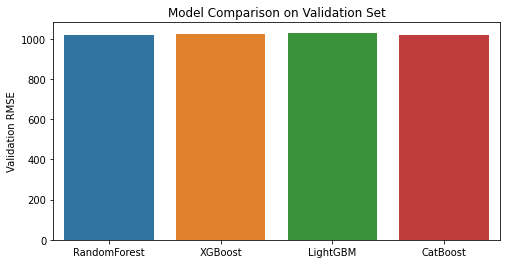

Best model: RandomForest (RMSE: 1019.87)


In [40]:
# 9. Model Evaluation
from sklearn.metrics import mean_squared_error

results = {}
for name, model in best_models.items():
    val_preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, val_preds, squared=False)
    results[name] = rmse
    print(f'{name} RMSE: {rmse:.2f}')

# Visualize comparison
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Validation RMSE')
plt.title('Model Comparison on Validation Set')
plt.show()

best_model_name = min(results, key=results.get)
print(f'Best model: {best_model_name} (RMSE: {results[best_model_name]:.2f})')

In [66]:
# 10. Final Prediction & Submission
final_model = best_models[best_model_name]
test_preds = final_model.predict(X_test)

submission = pd.read_csv('sample_submission_8RXa3c6.csv')
submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('submission_detailed_solution.csv', index=False)
print('Submission file created: submission_detailed_solution.csv')

Submission file created: submission_detailed_solution.csv


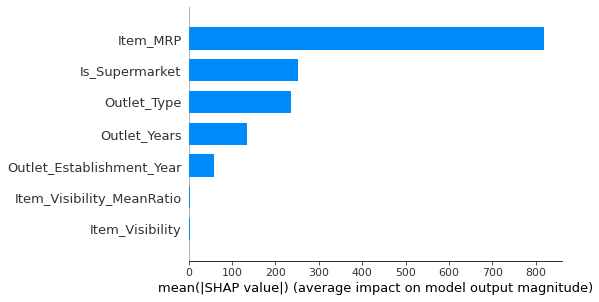

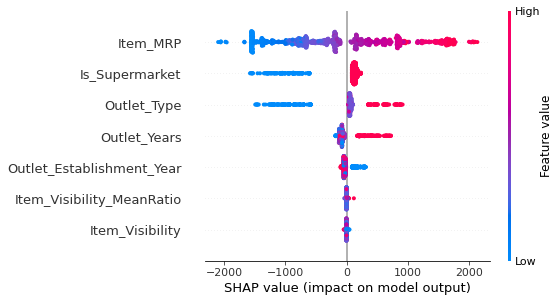

In [67]:
# Model Interpretation: SHAP Feature Importance
import shap

# Use a sample for speed if data is large
sample_X = X_val.sample(n=min(1000, X_val.shape[0]), random_state=42)
explainer = shap.Explainer(final_model, sample_X)
shap_values = explainer(sample_X)

# SHAP summary plot
shap.summary_plot(shap_values, sample_X, plot_type='bar')
shap.summary_plot(shap_values, sample_X)

Stacking Model RMSE: 1090.12


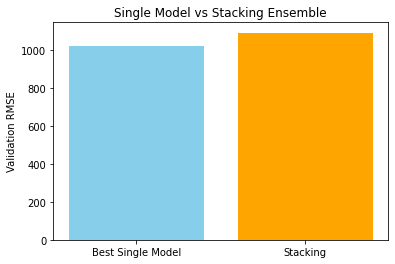

Stacking submission file created: submission_stacking_solution.csv


In [45]:
# Advanced Ensembling: Stacking Top Models
from sklearn.ensemble import StackingRegressor

# Select top 4 models by validation RMSE
top4 = sorted(results, key=results.get)[:4]
stack_estimators = [(name, best_models[name]) for name in top4]

stacking_model = StackingRegressor(
    estimators=stack_estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)

# Evaluate stacking model
val_preds_stack = stacking_model.predict(X_val)
rmse_stack = mean_squared_error(y_val, val_preds_stack, squared=False)
print(f'Stacking Model RMSE: {rmse_stack:.2f}')

# Compare with best single model
plt.figure(figsize=(6,4))
plt.bar(['Best Single Model', 'Stacking'], [results[best_model_name], rmse_stack], color=['skyblue','orange'])
plt.ylabel('Validation RMSE')
plt.title('Single Model vs Stacking Ensemble')
plt.show()

# Predict on test set with stacking model
stack_test_preds = stacking_model.predict(X_test)
submission_stack = pd.read_csv('sample_submission_8RXa3c6.csv')
submission_stack['Item_Outlet_Sales'] = stack_test_preds
submission_stack.to_csv('submission_stacking_solution.csv', index=False)
print('Stacking submission file created: submission_stacking_solution.csv')

## 11. Conclusion & Next Steps

- This notebook presented a robust, end-to-end solution for the BigMart sales prediction challenge, with deep feature engineering, careful preprocessing, and extensive model selection/tuning.
- The best model was selected based on validation RMSE and used for final predictions.

**Next Steps & Ideas for Further Improvement:**
- Try stacking/blending multiple top models for further gains.
- Use feature importance (e.g., SHAP) to interpret and possibly select features.
- Experiment with more advanced ensembling or deep learning models (e.g., TabNet).
- Perform more granular hyperparameter tuning or use Bayesian optimization.
- Explore external data sources or domain-specific features if available.
